In [2]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# 데이터 로드 및 생성

In [3]:
# train 데이터 불러오기
train = pd.read_csv('./train.csv')
train

,시점,구분,공급량
0,2013-01-01 00:00:00,A,2497.129
1,2013-01-01 01:00:00,A,2363.265
2,2013-01-01 02:00:00,A,2258.505
3,2013-01-01 03:00:00,A,2243.969
4,2013-01-01 04:00:00,A,2344.105
...,...,...,...
368083,2018-12-31 19:00:00,H,681.033
368084,2018-12-31 20:00:00,H,669.961
368085,2018-12-31 21:00:00,H,657.941
368086,2018-12-31 22:00:00,H,610.953


In [4]:
# test 데이터 불러오기
test = pd.read_csv('./test.csv')
test

,시점,구분
0,2019-01-01 00:00:00,A
1,2019-01-01 01:00:00,A
2,2019-01-01 02:00:00,A
3,2019-01-01 03:00:00,A
4,2019-01-01 04:00:00,A
...,...,...
15115,2019-03-31 19:00:00,H
15116,2019-03-31 20:00:00,H
15117,2019-03-31 21:00:00,H
15118,2019-03-31 22:00:00,H


In [5]:
# train과 test를 합쳐서 data 행성
data = train.append(test)
data

,시점,구분,공급량
0,2013-01-01 00:00:00,A,2497.129
1,2013-01-01 01:00:00,A,2363.265
2,2013-01-01 02:00:00,A,2258.505
3,2013-01-01 03:00:00,A,2243.969
4,2013-01-01 04:00:00,A,2344.105
...,...,...,...
15115,2019-03-31 19:00:00,H,NaN
15116,2019-03-31 20:00:00,H,NaN
15117,2019-03-31 21:00:00,H,NaN
15118,2019-03-31 22:00:00,H,NaN


In [6]:
# 시점 column을 index로 이동
data['시점'] = pd.to_datetime(data['시점'], format='%Y-%m-%d %H')
data.set_index('시점', inplace=True)
data

,구분,공급량
시점,,
2013-01-01 00:00:00,A,2497.129
2013-01-01 01:00:00,A,2363.265
2013-01-01 02:00:00,A,2258.505
2013-01-01 03:00:00,A,2243.969
2013-01-01 04:00:00,A,2344.105
...,...,...
2019-03-31 19:00:00,H,NaN
2019-03-31 20:00:00,H,NaN
2019-03-31 21:00:00,H,NaN


In [7]:
# 시점, 구분 순으로 오름차순 정렬
data.sort_values(['구분', '시점'], inplace=True)
data

,구분,공급량
시점,,
2013-01-01 00:00:00,A,2497.129
2013-01-01 01:00:00,A,2363.265
2013-01-01 02:00:00,A,2258.505
2013-01-01 03:00:00,A,2243.969
2013-01-01 04:00:00,A,2344.105
...,...,...
2019-03-31 19:00:00,H,NaN
2019-03-31 20:00:00,H,NaN
2019-03-31 21:00:00,H,NaN


In [8]:
# 유효일수 데이터 불러오기
vday = pd.read_csv('./한국가스공사_도시가스 민수용 일별 유효일수_20210901.csv', encoding='cp949')
vday

,연월일,유효일수
0,1985-01-01,0.94352
1,1985-01-02,1.00528
2,1985-01-03,1.00528
3,1985-01-04,1.00528
4,1985-01-05,0.97210
...,...,...
12503,2019-03-27,NaN
12504,2019-03-28,NaN
12505,2019-03-29,NaN
12506,2019-03-30,NaN


In [9]:
# 연월일 column을 index로 이동
vday['연월일'] = pd.to_datetime(vday['연월일'])
vday = vday.set_index('연월일')
vday

,유효일수
연월일,
1985-01-01,0.94352
1985-01-02,1.00528
1985-01-03,1.00528
1985-01-04,1.00528
1985-01-05,0.97210
...,...
2019-03-27,NaN
2019-03-28,NaN
2019-03-29,NaN


In [10]:
# 요일을 추출하여 저장
vday['요일'] = vday.index.weekday
vday

,유효일수,요일
연월일,,
1985-01-01,0.94352,1
1985-01-02,1.00528,2
1985-01-03,1.00528,3
1985-01-04,1.00528,4
1985-01-05,0.97210,5
...,...,...
2019-03-27,NaN,2
2019-03-28,NaN,3
2019-03-29,NaN,4


In [11]:
# 요일별 최빈 유효일수 값 저장
mode = vday.groupby('요일')['유효일수'].agg(**{'요일별 최빈값':lambda x:x.mode()}).reset_index()
mode

,요일,요일별 최빈값
0,0,1.00518
1,1,1.00528
2,2,1.00528
3,3,1.00528
4,4,1.00528
5,5,0.97210
6,6,0.95411


In [12]:
# 요일별 최빈값을 유효일수_에 저장
vday['유효일수_'] = np.nan
for i in vday['요일'].unique():
    vday['유효일수_'] = np.where(vday['요일'] == i, mode[mode['요일'] == i]['요일별 최빈값'], vday['유효일수_'])
vday

,유효일수,요일,유효일수_
연월일,,,
1985-01-01,0.94352,1,1.00528
1985-01-02,1.00528,2,1.00528
1985-01-03,1.00528,3,1.00528
1985-01-04,1.00528,4,1.00528
1985-01-05,0.97210,5,0.97210
...,...,...,...
2019-03-27,NaN,2,1.00528
2019-03-28,NaN,3,1.00528
2019-03-29,NaN,4,1.00528


In [13]:
# 2019년에 해당하는 데이터 유효일수_로 대체
vday['유효일수'] = np.where(vday['유효일수'].isna(), vday['유효일수_'], vday['유효일수'])
vday.drop(columns=['유효일수_'], inplace=True)
vday

,유효일수,요일
연월일,,
1985-01-01,0.94352,1
1985-01-02,1.00528,2
1985-01-03,1.00528,3
1985-01-04,1.00528,4
1985-01-05,0.97210,5
...,...,...
2019-03-27,1.00528,2
2019-03-28,1.00528,3
2019-03-29,1.00528,4


In [14]:
# 휴일에 해당하는 1월 1일 화요일에 해당하는 유효일수 값 확인
vday[(vday.index.month == 1) & (vday.index.day == 1) & (vday['요일'] == 1)]

,유효일수,요일
연월일,,
1985-01-01,0.94352,1
1991-01-01,0.94352,1
2002-01-01,0.94352,1
2008-01-01,0.94352,1
2013-01-01,0.94352,1
2019-01-01,1.00528,1


In [15]:
# 확인한 값으로 대체
vday.loc['2019-1-1','유효일수'] = 0.94352

In [16]:
# 1월 2일 수요일 값 확인
vday[(vday.index.month == 1) & (vday.index.day == 2) & (vday['요일'] == 2)]

,유효일수,요일
연월일,,
1985-01-02,1.00528,2
1991-01-02,1.00528,2
2002-01-02,1.00528,2
2008-01-02,1.00528,2
2013-01-02,1.00528,2
2019-01-02,1.00528,2


In [17]:
# 19년 설날이 월화수 였으므로 2002년 설날 전후 휴일 데이터 확인
vday['2002-2-10':'2002-2-16']

,유효일수,요일
연월일,,
2002-02-10,0.94304,6
2002-02-11,0.92928,0
2002-02-12,0.87907,1
2002-02-13,0.95152,2
2002-02-14,1.03643,3
2002-02-15,1.05545,4
2002-02-16,0.95975,5


In [18]:
# 해당 값으로 설날 데이터 대체
vday.loc['2019-2-3','유효일수'] = 0.94304
vday.loc['2019-2-4','유효일수'] = 0.92928
vday.loc['2019-2-5','유효일수'] = 0.87907
vday.loc['2019-2-6','유효일수'] = 0.95152
vday.loc['2019-2-7','유효일수'] = 1.03643
vday.loc['2019-2-8','유효일수'] = 1.05545
vday.loc['2019-2-9','유효일수'] = 0.95975

In [19]:
# 3월 1일 금요일 값 확인
vday[(vday.index.month == 3) & (vday.index.day == 1) & (vday['요일'] == 4)]

,유효일수,요일
연월일,,
1985-03-01,0.93477,4
1991-03-01,0.93477,4
1996-03-01,0.93477,4
2002-03-01,0.93477,4
2013-03-01,0.93477,4
2019-03-01,1.00528,4


In [20]:
# 확인한 값으로 대체
vday.loc['2019-3-1','유효일수'] = 0.93477

In [21]:
# 3월 2일 토요일 값 확인
vday[(vday.index.month == 3) & (vday.index.day == 2) & (vday['요일'] == 5)]

,유효일수,요일
연월일,,
1985-03-02,0.95975,5
1991-03-02,0.95975,5
1996-03-02,0.95975,5
2002-03-02,0.95975,5
2013-03-02,0.95975,5
2019-03-02,0.97210,5


In [22]:
# 확인한 값으로 대체
vday.loc['2019-3-2','유효일수'] = 0.95975

In [23]:
# 생성된 vday를 data에 결합
data['vday'] = vday['유효일수']
data['vday'] = data['vday'].fillna(method='ffill')
data

,구분,공급량,vday
시점,,,
2013-01-01 00:00:00,A,2497.129,0.94352
2013-01-01 01:00:00,A,2363.265,0.94352
2013-01-01 02:00:00,A,2258.505,0.94352
2013-01-01 03:00:00,A,2243.969,0.94352
2013-01-01 04:00:00,A,2344.105,0.94352
...,...,...,...
2019-03-31 19:00:00,H,NaN,0.95411
2019-03-31 20:00:00,H,NaN,0.95411
2019-03-31 21:00:00,H,NaN,0.95411


In [24]:
# 기상 데이터 불러오기
weather = pd.read_csv('./기상.csv', encoding='cp949')
weather

,지점,지점명,일시,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
0,108,서울,2010-01-01 0:00,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
1,108,서울,2010-01-01 1:00,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2,108,서울,2010-01-01 2:00,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
3,108,서울,2010-01-01 3:00,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
4,108,서울,2010-01-01 4:00,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...
81041,108,서울,2019-03-31 19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81042,108,서울,2019-03-31 20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81043,108,서울,2019-03-31 21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81044,108,서울,2019-03-31 22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# 일시 column을 dt형으로 변환 후 index로 이동
weather['일시'] = pd.to_datetime(weather['일시'], format='%Y-%m-%d %H')
weather.set_index('일시', inplace=True)
weather

,지점,지점명,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
일시,,,,,,,,,,,
2010-01-01 00:00:00,108,서울,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
2010-01-01 01:00:00,108,서울,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2010-01-01 02:00:00,108,서울,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
2010-01-01 03:00:00,108,서울,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
2010-01-01 04:00:00,108,서울,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,108,서울,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 20:00:00,108,서울,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 21:00:00,108,서울,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# 필요한 columns만 추출
weather = weather[['기온(°C)', '풍속(m/s)', '증기압(hPa)', '이슬점온도(°C)', '지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)',
                   '30cm 지중온도(°C)']]
weather

,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
2010-01-01 01:00:00,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2010-01-01 02:00:00,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
2010-01-01 03:00:00,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
2010-01-01 04:00:00,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# 없는 날짜에 대한 데이터 NaN으로 생성
weather.loc['2011-10-12 18:00:00'] = np.nan
weather.loc['2012-11-29 02:00:00'] = np.nan
weather

,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
2010-01-01 01:00:00,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2010-01-01 02:00:00,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
2010-01-01 03:00:00,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
2010-01-01 04:00:00,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# 생성된 날짜 datetime형으로 변형
weather.index = pd.to_datetime(weather.index, format='%Y-%m-%d %H')
weather

,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
2010-01-01 01:00:00,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2010-01-01 02:00:00,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
2010-01-01 03:00:00,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
2010-01-01 04:00:00,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# index로 정렬
weather = weather.sort_index()
weather

,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
2010-01-01 01:00:00,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2010-01-01 02:00:00,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
2010-01-01 03:00:00,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
2010-01-01 04:00:00,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# 결측을 interpolation으로 대체
for i in weather.columns:
    weather[:'2018'][i] = weather[:'2018'][i].interpolate()
weather

,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
2010-01-01 01:00:00,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2010-01-01 02:00:00,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
2010-01-01 03:00:00,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
2010-01-01 04:00:00,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# 체감온도 계산
weather['체감온도'] = 13.12 + 0.6215*weather['기온(°C)'] - 11.37*weather['풍속(m/s)']**0.16 + 0.3965*weather['기온(°C)']*weather['풍속(m/s)']**0.16
weather.drop(columns=['풍속(m/s)'], inplace=True)
weather

,기온(°C),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C),체감온도
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6,-13.118169
2010-01-01 01:00:00,-11.0,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6,-9.913670
2010-01-01 02:00:00,-11.1,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6,-10.947262
2010-01-01 03:00:00,-12.1,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6,-11.830500
2010-01-01 04:00:00,-12.3,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6,-11.670036
...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# 칼럼 명 간단하게 변경
weather.columns = ['기온', '증기압', '이슬점', '지면', '지중_5', '지중_10', '지중_20', '지중_30', '체감']
weather

,기온,증기압,이슬점,지면,지중_5,지중_10,지중_20,지중_30,체감
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6,-13.118169
2010-01-01 01:00:00,-11.0,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6,-9.913670
2010-01-01 02:00:00,-11.1,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6,-10.947262
2010-01-01 03:00:00,-12.1,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6,-11.830500
2010-01-01 04:00:00,-12.3,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6,-11.670036
...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# seasonal 만들어 주는 함수
def create_seasonal(data, y):
    
    # 1년 주기와 하루 주기를 가지는 데이터 생성
    result = seasonal_decompose(data[data.index.year < 2019][y], period=24*365+6) # 24*365+6을 주기로 seasonal_decompose 실행
    result = seasonal_decompose(result.seasonal, period=24) # 생성된 seasonal데이터를 다시 주기 24로 decompose 실행
    data['year'] = result.trend # 생성된 trend를 year에 할당
    data['day'] = result.seasonal # 생성된 seasonal을 day에 할당
    
    # 결측치를 주기와 같은 값으로 대체
    data['year_'] = data['year'].shift(-24*365+6) # year의 위쪽 결측을 한번 주기를 shift하여 채움
    data['year__'] = data['year'].shift(24*365+6) # year의 아래쪽 결측을 한번 주기를 shift하여 채움
    data['year'] = np.where(data['year'].isna(), data['year_'], data['year']) # 결측을 채워진 값들로 대체
    data['year'] = np.where(data['year'].isna(), data['year__'], data['year'])
    data.drop(columns=['year_', 'year__'], inplace=True) # 임시 생성한 칼럼 삭제

    data['day_'] = data['day'].shift(-24*365)
    data['day__'] = data['day'].shift(24*365)
    data['day'] = np.where(data['day'].isna(), data['day_'], data['day'])
    data['day'] = np.where(data['day'].isna(), data['day__'], data['day'])
    data.drop(columns=['day_', 'day__'], inplace=True)
    
    return data

In [34]:
# 각각의 날씨 변수에 대한 주기들을 data에 결합
for x in weather.columns:
    X = weather[[x]]
    X = create_seasonal(X, x)
    data[str(x)+'_year'] = X['year']
    data[str(x)+'_day'] = X['day']
data

,구분,공급량,vday,기온_year,기온_day,증기압_year,증기압_day,이슬점_year,이슬점_day,지면_year,...,지중_5_year,지중_5_day,지중_10_year,지중_10_day,지중_20_year,지중_20_day,지중_30_year,지중_30_day,체감_year,체감_day
시점,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,A,2497.129,0.94352,-15.396796,-0.007450,-8.155138,0.012419,-14.733236,0.025919,-16.153496,...,-15.257624,0.020093,-14.766306,0.017411,-13.954800,-0.007649,-13.128765,-0.008018,-16.562741,0.000551
2013-01-01 01:00:00,A,2363.265,0.94352,-15.366578,-0.122558,-8.124135,-0.002164,-14.582316,0.002846,-16.199317,...,-15.268537,-0.075464,-14.778518,-0.002626,-13.961280,-0.004749,-13.130819,-0.006373,-16.498226,-0.127544
2013-01-01 02:00:00,A,2258.505,0.94352,-15.327770,-0.110122,-8.095218,-0.011165,-14.441424,-0.010658,-16.234206,...,-15.276850,-0.086920,-14.789429,-0.022856,-13.968282,-0.005917,-13.132874,-0.002856,-16.437052,-0.111903
2013-01-01 03:00:00,A,2243.969,0.94352,-15.286363,0.009134,-8.067606,-0.003130,-14.311211,-0.006773,-16.271968,...,-15.283603,-0.010493,-14.799041,-0.024947,-13.975806,-0.009919,-13.135189,0.001309,-16.387217,0.007319
2013-01-01 04:00:00,A,2344.105,0.94352,-15.239754,0.119913,-8.037131,-0.000813,-14.173447,-0.004541,-16.300363,...,-15.289059,0.081148,-14.807873,-0.002734,-13.983591,-0.007068,-13.137505,0.003429,-16.313137,0.113042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,H,NaN,0.95411,-2.309277,-0.118933,-4.148184,-0.000269,-3.428038,0.003173,-2.562504,...,-2.947256,-0.075545,-3.320757,-0.001961,-3.763727,-0.001268,-4.286250,-0.007315,-2.409067,-0.123036
2019-03-31 20:00:00,H,NaN,0.95411,-2.308583,-0.108836,-4.208904,-0.008805,-3.584605,-0.008380,-2.587071,...,-2.949682,-0.091205,-3.323177,-0.024495,-3.763793,-0.006787,-4.288121,-0.008745,-2.425852,-0.107376
2019-03-31 21:00:00,H,NaN,0.95411,-2.307881,0.008301,-4.277955,-0.002947,-3.754709,-0.009094,-2.585590,...,-2.953407,-0.014424,-3.326377,-0.029231,-3.763598,-0.013570,-4.286867,-0.008991,-2.440874,0.003801


In [35]:
# 1시간, 24시간 전 데이터 생성
for i in (1, 24):
    data['공급량-'+str(i)] = data.groupby(['구분'])['공급량'].shift(i)
data = data[data.index >= '2013-1-2']
data

,구분,공급량,vday,기온_year,기온_day,증기압_year,증기압_day,이슬점_year,이슬점_day,지면_year,...,지중_10_year,지중_10_day,지중_20_year,지중_20_day,지중_30_year,지중_30_day,체감_year,체감_day,공급량-1,공급량-24
시점,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00,A,2345.481,1.00528,-14.075396,-0.007450,-7.581848,0.012419,-13.194493,0.025919,-15.346730,...,-14.409513,0.017411,-13.842732,-0.007649,-13.097011,-0.008018,-14.875508,0.000551,2494.457,2497.129
2013-01-02 01:00:00,A,2185.065,1.00528,-14.089245,-0.122558,-7.594354,-0.002164,-13.321319,0.002846,-15.290788,...,-14.382711,-0.002626,-13.828411,-0.004749,-13.090492,-0.006373,-14.903040,-0.127544,2345.481,2363.265
2013-01-02 02:00:00,A,2122.561,1.00528,-14.116895,-0.110122,-7.609204,-0.011165,-13.449969,-0.010658,-15.243437,...,-14.353044,-0.022856,-13.813832,-0.005917,-13.083713,-0.002856,-14.937196,-0.111903,2185.065,2258.505
2013-01-02 03:00:00,A,2238.889,1.00528,-14.156261,0.009134,-7.625878,-0.003130,-13.578620,-0.006773,-15.204152,...,-14.320514,-0.024947,-13.797951,-0.009919,-13.075633,0.001309,-14.967990,0.007319,2122.561,2243.969
2013-01-02 04:00:00,A,2475.521,1.00528,-14.207344,0.119913,-7.642813,-0.000813,-13.705448,-0.004541,-15.168768,...,-14.286421,-0.002734,-13.781289,-0.007068,-13.067293,0.003429,-15.023501,0.113042,2238.889,2344.105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,H,NaN,0.95411,-2.309277,-0.118933,-4.148184,-0.000269,-3.428038,0.003173,-2.562504,...,-3.320757,-0.001961,-3.763727,-0.001268,-4.286250,-0.007315,-2.409067,-0.123036,NaN,NaN
2019-03-31 20:00:00,H,NaN,0.95411,-2.308583,-0.108836,-4.208904,-0.008805,-3.584605,-0.008380,-2.587071,...,-3.323177,-0.024495,-3.763793,-0.006787,-4.288121,-0.008745,-2.425852,-0.107376,NaN,NaN
2019-03-31 21:00:00,H,NaN,0.95411,-2.307881,0.008301,-4.277955,-0.002947,-3.754709,-0.009094,-2.585590,...,-3.326377,-0.029231,-3.763598,-0.013570,-4.286867,-0.008991,-2.440874,0.003801,NaN,NaN


In [36]:
# 이상치 제거를 위해 구분별로 분리
A = data[data['구분'] == 'A']
B = data[data['구분'] == 'B']
C = data[data['구분'] == 'C']
D = data[data['구분'] == 'D']
E = data[data['구분'] == 'E']
G = data[data['구분'] == 'G']
H = data[data['구분'] == 'H']

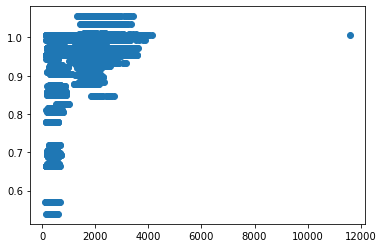

In [37]:
plt.scatter(A['공급량'], A['vday']);

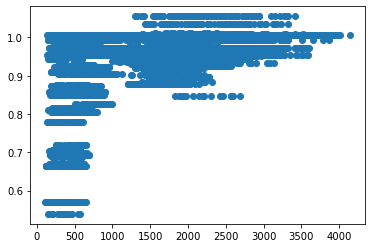

In [38]:
A = A.drop(A[A['공급량'] >= 10000].index)
plt.scatter(A['공급량'], A['vday']);

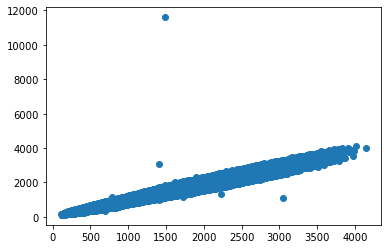

In [39]:
plt.scatter(A['공급량'], A['공급량-1']);

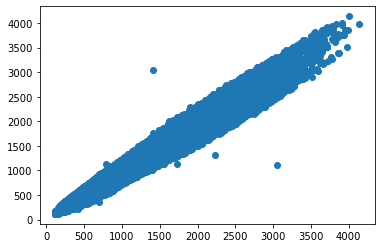

In [40]:
A = A.drop(A[A['공급량-1'] >= 10000].index)
plt.scatter(A['공급량'], A['공급량-1']);

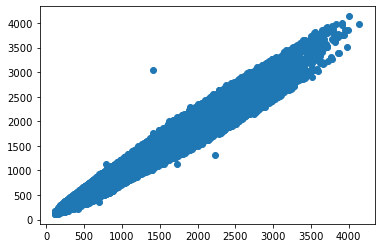

In [41]:
A = A.drop(A[A['공급량'] >= 3000].index & A[A['공급량-1'] <= 1500].index)
plt.scatter(A['공급량'], A['공급량-1']);

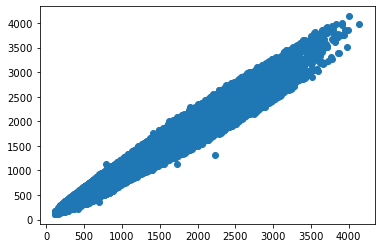

In [42]:
A = A.drop(A[A['공급량'] <= 1500].index & A[A['공급량-1'] >= 3000].index)
plt.scatter(A['공급량'], A['공급량-1']);

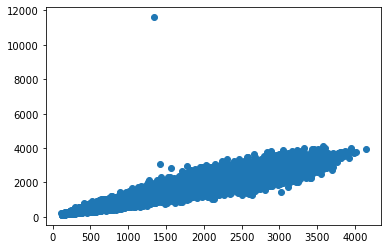

In [43]:
plt.scatter(A['공급량'], A['공급량-24']);

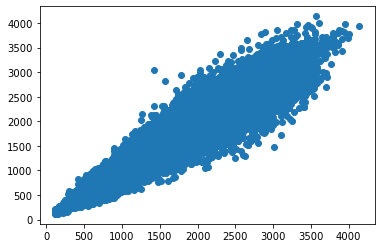

In [44]:
A = A.drop(A[A['공급량-24'] >= 10000].index)
plt.scatter(A['공급량'], A['공급량-24']);

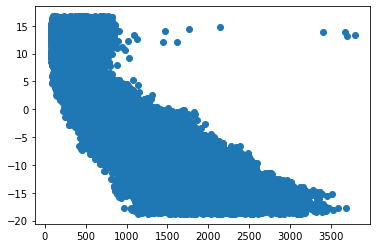

In [45]:
plt.scatter(B['공급량'], B['기온_year']);

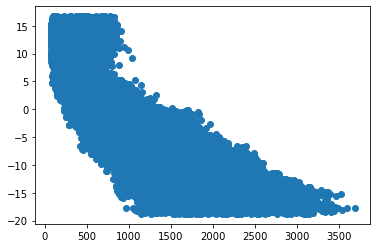

In [46]:
B = B.drop(B[B['공급량'] >= 1000].index & B[B['기온_year'] >= 10].index)
plt.scatter(B['공급량'], B['기온_year']);

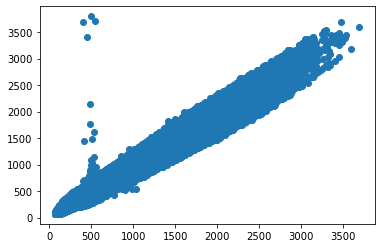

In [47]:
plt.scatter(B['공급량'], B['공급량-1']);

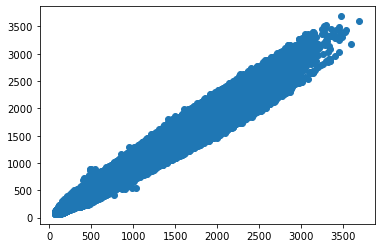

In [48]:
B = B.drop(B[B['공급량'] <= 600].index & B[B['공급량-1'] >= 900].index)
plt.scatter(B['공급량'], B['공급량-1']);

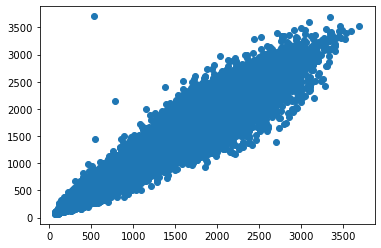

In [49]:
plt.scatter(B['공급량'], B['공급량-24']);

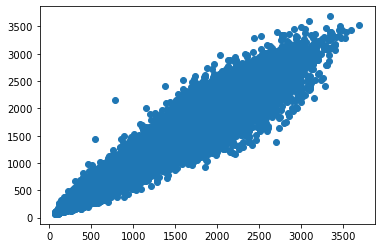

In [50]:
B = B.drop(B[B['공급량'] <= 1000].index & B[B['공급량-24'] >= 3500].index)
plt.scatter(B['공급량'], B['공급량-24']);

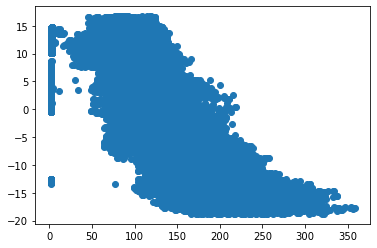

In [51]:
plt.scatter(C['공급량'], C['기온_year']);

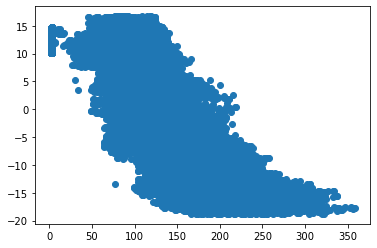

In [52]:
C = C.drop(C[C['공급량'] <= 15].index & C[C['기온_year'] <= 10].index)
plt.scatter(C['공급량'], C['기온_year']);

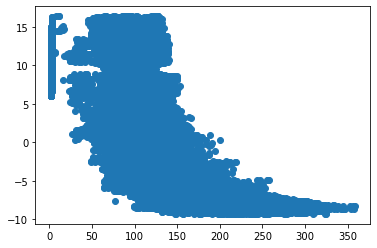

In [53]:
plt.scatter(C['공급량'], C['증기압_year']);

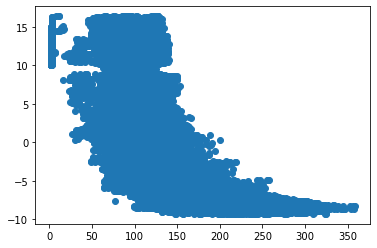

In [54]:
C = C.drop(C[C['공급량'] <= 10].index & C[C['증기압_year'] <= 10].index)
plt.scatter(C['공급량'], C['증기압_year']);

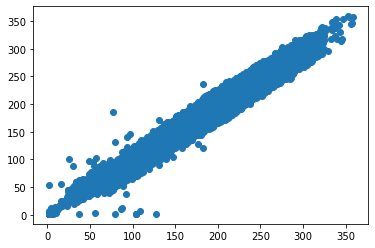

In [55]:
plt.scatter(C['공급량'], C['공급량-1']);

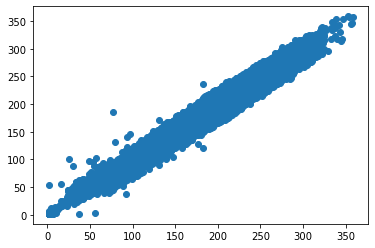

In [56]:
C = C.drop(C[C['공급량'] >= 60].index & C[C['공급량-1'] <= 30].index)
plt.scatter(C['공급량'], C['공급량-1']);

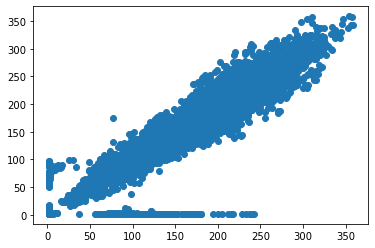

In [57]:
plt.scatter(C['공급량'], C['공급량-24']);

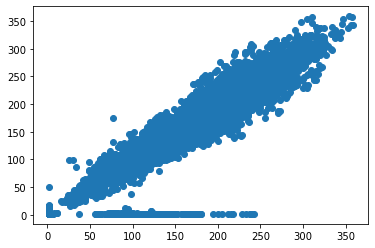

In [58]:
C = C.drop(C[C['공급량'] <= 20].index & C[C['공급량-24'] >= 50].index)
plt.scatter(C['공급량'], C['공급량-24']);

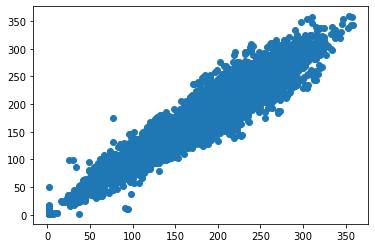

In [59]:
C = C.drop(C[C['공급량'] >= 50].index & C[C['공급량-24'] <= 10].index)
plt.scatter(C['공급량'], C['공급량-24']);

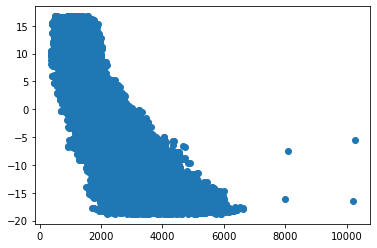

In [60]:
plt.scatter(G['공급량'], G['기온_year']);

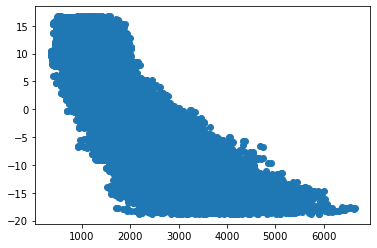

In [61]:
G = G.drop(G[G['공급량'] >= 8000].index)
plt.scatter(G['공급량'], G['기온_year']);

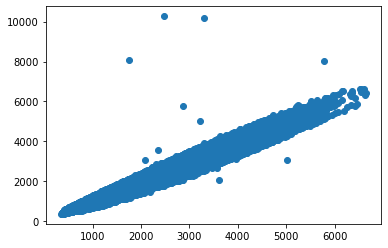

In [62]:
plt.scatter(G['공급량'], G['공급량-1']);

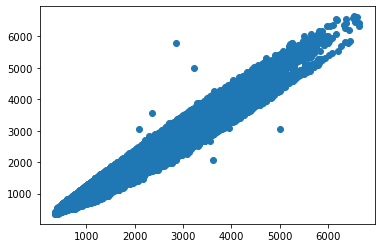

In [63]:
G = G.drop(G[G['공급량'] <= 6000].index & G[G['공급량-1'] >= 8000].index)
plt.scatter(G['공급량'], G['공급량-1']);

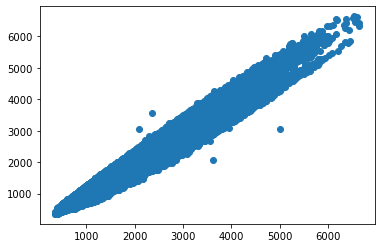

In [64]:
G = G.drop(G[G['공급량'] <= 3500].index & G[G['공급량-1'] >= 4500].index)
plt.scatter(G['공급량'], G['공급량-1']);

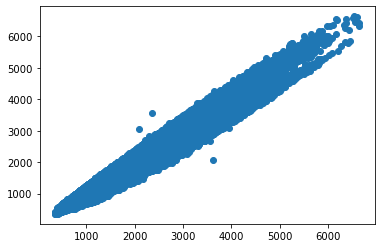

In [65]:
G = G.drop(G[G['공급량'] >= 4500].index & G[G['공급량-1'] <= 3100].index)
plt.scatter(G['공급량'], G['공급량-1']);

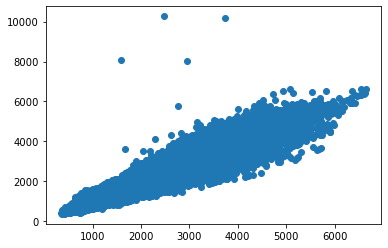

In [66]:
plt.scatter(G['공급량'], G['공급량-24']);

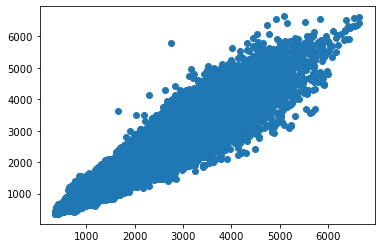

In [67]:
G = G.drop(G[G['공급량'] <= 4000].index & G[G['공급량-24'] >= 8000].index)
plt.scatter(G['공급량'], G['공급량-24']);

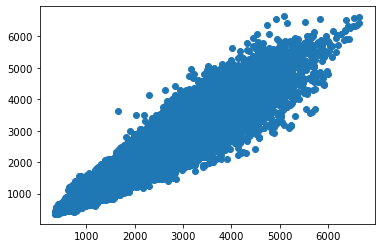

In [68]:
G = G.drop(G[G['공급량'] <= 3000].index & G[G['공급량-24'] >= 5500].index)
plt.scatter(G['공급량'], G['공급량-24']);

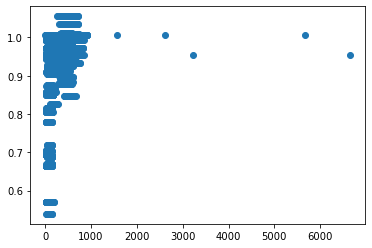

In [69]:
plt.scatter(H['공급량'], H['vday']);

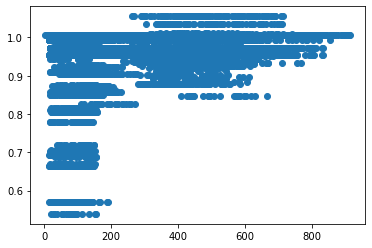

In [70]:
H = H.drop(H[H['공급량'] >= 1500].index)
plt.scatter(H['공급량'], H['vday']);

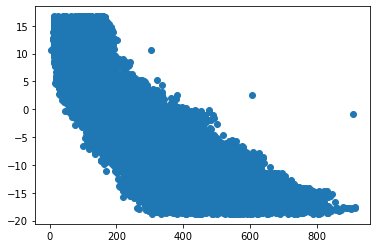

In [71]:
plt.scatter(H['공급량'], H['기온_year']);

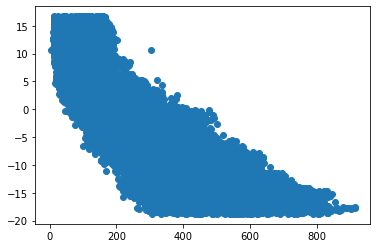

In [72]:
H = H.drop(H[H['공급량'] >= 600].index & H[H['기온_year'] >= -1].index)
plt.scatter(H['공급량'], H['기온_year']);

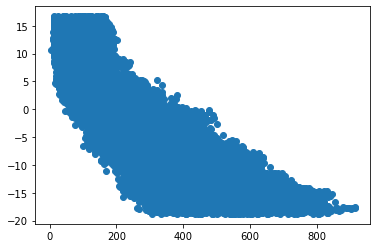

In [73]:
H = H.drop(H[H['공급량'] >= 300].index & H[H['기온_year'] >= 10].index)
plt.scatter(H['공급량'], H['기온_year']);

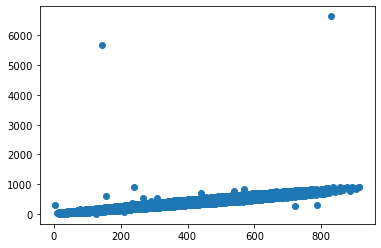

In [74]:
plt.scatter(H['공급량'], H['공급량-1']);

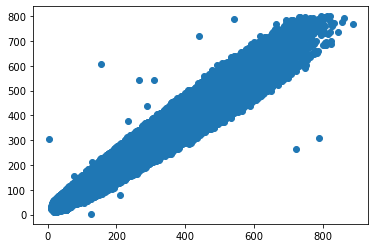

In [75]:
H = H.drop(H[H['공급량-1'] >= 800].index)
plt.scatter(H['공급량'], H['공급량-1']);

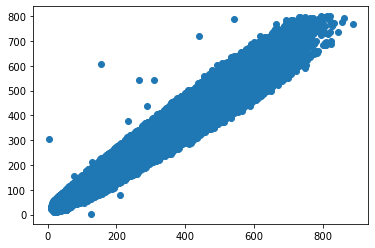

In [76]:
H = H.drop(H[H['공급량'] >= 600].index & H[H['공급량-1'] <= 400].index)
plt.scatter(H['공급량'], H['공급량-1']);

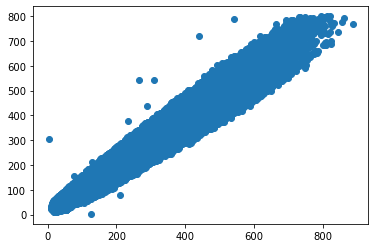

In [77]:
H = H.drop(H[H['공급량'] <= 250].index & H[H['공급량-1'] >= 400].index)
plt.scatter(H['공급량'], H['공급량-1']);

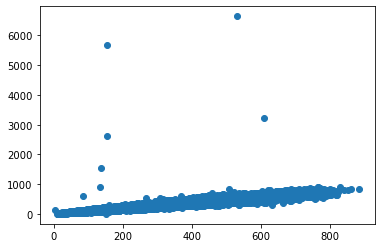

In [78]:
plt.scatter(H['공급량'], H['공급량-24']);

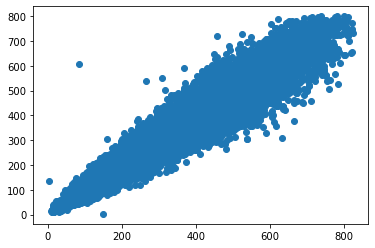

In [79]:
H = H.drop(H[H['공급량-24'] >= 800].index)
plt.scatter(H['공급량'], H['공급량-24']);

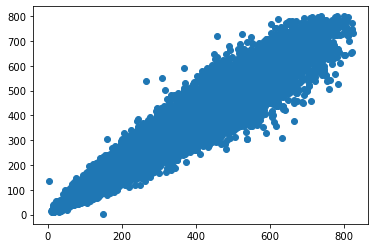

In [80]:
H = H.drop(H[H['공급량-24'] >= 500].index & H[H['공급량'] <= 100].index)
plt.scatter(H['공급량'], H['공급량-24']);

In [81]:
data = A.append(B).append(C).append(D).append(E).append(G).append(H)
data

,구분,공급량,vday,기온_year,기온_day,증기압_year,증기압_day,이슬점_year,이슬점_day,지면_year,...,지중_10_year,지중_10_day,지중_20_year,지중_20_day,지중_30_year,지중_30_day,체감_year,체감_day,공급량-1,공급량-24
시점,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00,A,2345.481,1.00528,-14.075396,-0.007450,-7.581848,0.012419,-13.194493,0.025919,-15.346730,...,-14.409513,0.017411,-13.842732,-0.007649,-13.097011,-0.008018,-14.875508,0.000551,2494.457,2497.129
2013-01-02 01:00:00,A,2185.065,1.00528,-14.089245,-0.122558,-7.594354,-0.002164,-13.321319,0.002846,-15.290788,...,-14.382711,-0.002626,-13.828411,-0.004749,-13.090492,-0.006373,-14.903040,-0.127544,2345.481,2363.265
2013-01-02 02:00:00,A,2122.561,1.00528,-14.116895,-0.110122,-7.609204,-0.011165,-13.449969,-0.010658,-15.243437,...,-14.353044,-0.022856,-13.813832,-0.005917,-13.083713,-0.002856,-14.937196,-0.111903,2185.065,2258.505
2013-01-02 03:00:00,A,2238.889,1.00528,-14.156261,0.009134,-7.625878,-0.003130,-13.578620,-0.006773,-15.204152,...,-14.320514,-0.024947,-13.797951,-0.009919,-13.075633,0.001309,-14.967990,0.007319,2122.561,2243.969
2013-01-02 04:00:00,A,2475.521,1.00528,-14.207344,0.119913,-7.642813,-0.000813,-13.705448,-0.004541,-15.168768,...,-14.286421,-0.002734,-13.781289,-0.007068,-13.067293,0.003429,-15.023501,0.113042,2238.889,2344.105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,H,NaN,0.95411,-2.309277,-0.118933,-4.148184,-0.000269,-3.428038,0.003173,-2.562504,...,-3.320757,-0.001961,-3.763727,-0.001268,-4.286250,-0.007315,-2.409067,-0.123036,NaN,NaN
2019-03-31 20:00:00,H,NaN,0.95411,-2.308583,-0.108836,-4.208904,-0.008805,-3.584605,-0.008380,-2.587071,...,-3.323177,-0.024495,-3.763793,-0.006787,-4.288121,-0.008745,-2.425852,-0.107376,NaN,NaN
2019-03-31 21:00:00,H,NaN,0.95411,-2.307881,0.008301,-4.277955,-0.002947,-3.754709,-0.009094,-2.585590,...,-3.326377,-0.029231,-3.763598,-0.013570,-4.286867,-0.008991,-2.440874,0.003801,NaN,NaN


In [82]:
# month를 추출하여 저장
data['month'] = data.index.month
data

,구분,공급량,vday,기온_year,기온_day,증기압_year,증기압_day,이슬점_year,이슬점_day,지면_year,...,지중_10_day,지중_20_year,지중_20_day,지중_30_year,지중_30_day,체감_year,체감_day,공급량-1,공급량-24,month
시점,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00,A,2345.481,1.00528,-14.075396,-0.007450,-7.581848,0.012419,-13.194493,0.025919,-15.346730,...,0.017411,-13.842732,-0.007649,-13.097011,-0.008018,-14.875508,0.000551,2494.457,2497.129,1
2013-01-02 01:00:00,A,2185.065,1.00528,-14.089245,-0.122558,-7.594354,-0.002164,-13.321319,0.002846,-15.290788,...,-0.002626,-13.828411,-0.004749,-13.090492,-0.006373,-14.903040,-0.127544,2345.481,2363.265,1
2013-01-02 02:00:00,A,2122.561,1.00528,-14.116895,-0.110122,-7.609204,-0.011165,-13.449969,-0.010658,-15.243437,...,-0.022856,-13.813832,-0.005917,-13.083713,-0.002856,-14.937196,-0.111903,2185.065,2258.505,1
2013-01-02 03:00:00,A,2238.889,1.00528,-14.156261,0.009134,-7.625878,-0.003130,-13.578620,-0.006773,-15.204152,...,-0.024947,-13.797951,-0.009919,-13.075633,0.001309,-14.967990,0.007319,2122.561,2243.969,1
2013-01-02 04:00:00,A,2475.521,1.00528,-14.207344,0.119913,-7.642813,-0.000813,-13.705448,-0.004541,-15.168768,...,-0.002734,-13.781289,-0.007068,-13.067293,0.003429,-15.023501,0.113042,2238.889,2344.105,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,H,NaN,0.95411,-2.309277,-0.118933,-4.148184,-0.000269,-3.428038,0.003173,-2.562504,...,-0.001961,-3.763727,-0.001268,-4.286250,-0.007315,-2.409067,-0.123036,NaN,NaN,3
2019-03-31 20:00:00,H,NaN,0.95411,-2.308583,-0.108836,-4.208904,-0.008805,-3.584605,-0.008380,-2.587071,...,-0.024495,-3.763793,-0.006787,-4.288121,-0.008745,-2.425852,-0.107376,NaN,NaN,3
2019-03-31 21:00:00,H,NaN,0.95411,-2.307881,0.008301,-4.277955,-0.002947,-3.754709,-0.009094,-2.585590,...,-0.029231,-3.763598,-0.013570,-4.286867,-0.008991,-2.440874,0.003801,NaN,NaN,3


In [83]:
# month변수에 구분 및 각 월의 평균 공급량을 계산하여 대체
for x in data['구분'].unique():
    for h in data['month'].unique():
        data['month'] = np.where((data['구분'] == x) & (data['month'] == h),
                                 data[(data['구분'] == x) & (data['month'] == h)]['공급량'].mean(),
                                 data['month'])
data

,구분,공급량,vday,기온_year,기온_day,증기압_year,증기압_day,이슬점_year,이슬점_day,지면_year,...,지중_10_day,지중_20_year,지중_20_day,지중_30_year,지중_30_day,체감_year,체감_day,공급량-1,공급량-24,month
시점,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00,A,2345.481,1.00528,-14.075396,-0.007450,-7.581848,0.012419,-13.194493,0.025919,-15.346730,...,0.017411,-13.842732,-0.007649,-13.097011,-0.008018,-14.875508,0.000551,2494.457,2497.129,2297.494201
2013-01-02 01:00:00,A,2185.065,1.00528,-14.089245,-0.122558,-7.594354,-0.002164,-13.321319,0.002846,-15.290788,...,-0.002626,-13.828411,-0.004749,-13.090492,-0.006373,-14.903040,-0.127544,2345.481,2363.265,2297.494201
2013-01-02 02:00:00,A,2122.561,1.00528,-14.116895,-0.110122,-7.609204,-0.011165,-13.449969,-0.010658,-15.243437,...,-0.022856,-13.813832,-0.005917,-13.083713,-0.002856,-14.937196,-0.111903,2185.065,2258.505,2297.494201
2013-01-02 03:00:00,A,2238.889,1.00528,-14.156261,0.009134,-7.625878,-0.003130,-13.578620,-0.006773,-15.204152,...,-0.024947,-13.797951,-0.009919,-13.075633,0.001309,-14.967990,0.007319,2122.561,2243.969,2297.494201
2013-01-02 04:00:00,A,2475.521,1.00528,-14.207344,0.119913,-7.642813,-0.000813,-13.705448,-0.004541,-15.168768,...,-0.002734,-13.781289,-0.007068,-13.067293,0.003429,-15.023501,0.113042,2238.889,2344.105,2297.494201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,H,NaN,0.95411,-2.309277,-0.118933,-4.148184,-0.000269,-3.428038,0.003173,-2.562504,...,-0.001961,-3.763727,-0.001268,-4.286250,-0.007315,-2.409067,-0.123036,NaN,NaN,332.351503
2019-03-31 20:00:00,H,NaN,0.95411,-2.308583,-0.108836,-4.208904,-0.008805,-3.584605,-0.008380,-2.587071,...,-0.024495,-3.763793,-0.006787,-4.288121,-0.008745,-2.425852,-0.107376,NaN,NaN,332.351503
2019-03-31 21:00:00,H,NaN,0.95411,-2.307881,0.008301,-4.277955,-0.002947,-3.754709,-0.009094,-2.585590,...,-0.029231,-3.763598,-0.013570,-4.286867,-0.008991,-2.440874,0.003801,NaN,NaN,332.351503


In [1767]:
# 19년 공급량을 예측
PRED = pd.DataFrame() # 예측값을 저장할 데이터프레임 생성

for x in data['구분'].unique(): # 구분별로 따로 모델 생성
    A = data[data['구분'] == x]
    
    test = A[A.index.year == 2019]
    train = A[A.index.year != 2019]
    
    models = {} # 요일별, 시간별 모델을 저장할 딕셔너리 생성
    
    for i in range(168): # 월별, 시간별 모델을 따로 생성
        X = train[train.index.hour + train.index.weekday*24 == i]

        LR = LinearRegression()
        
        X_train = X['2014':'2015'].drop(columns=['구분', '공급량'])
        y_train = X['2014':'2015']['공급량']
        
        models[i] = LR.fit(X_train, y_train)
        
    for i in range(2160):
        flag = test.iloc[i:i+1,:].index.hour[0] + test.iloc[i:i+1,:].index.weekday[0]*24 # 예측할 순번에 있는 요일, 시간을 flag에 저장

        pred = models[flag].predict(test.iloc[i:i+1,2:]) #해당 row에 있는 데이터로 예측값 생성
        test.loc[i:i+1, '공급량'] = pred[0] # 생성된 예측값을 자리에 맞게 저장
        test.loc[i+1:i+2, '공급량-1'] = pred[0]
        test.loc[i+24:i+25, '공급량-24'] = pred[0]

    PRED = PRED.append(test) # 저장된 데이터프레임을 결합
    
PRED

,구분,공급량,vday,기온_year,기온_day,증기압_year,증기압_day,이슬점_year,이슬점_day,지면_year,...,지중_10_day,지중_20_year,지중_20_day,지중_30_year,지중_30_day,체감_year,체감_day,month,공급량-1,공급량-24
시점,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,A,2303.477303,0.94352,-15.465375,-0.007450,-8.198940,0.012419,-14.897362,0.025919,-15.846531,...,0.017411,-13.924746,-0.007649,-13.119240,-0.008018,-16.622988,0.000551,2297.494201,2583.340000,2429.750000
2019-01-01 01:00:00,A,2024.315484,0.94352,-15.491114,-0.122558,-8.218175,-0.002164,-14.976507,0.002846,-15.860299,...,-0.002626,-13.927051,-0.004749,-13.119989,-0.006373,-16.680623,-0.127544,2297.494201,2303.477303,2228.795000
2019-01-01 02:00:00,A,1883.471684,0.94352,-15.510346,-0.110122,-8.233506,-0.011165,-15.037944,-0.010658,-15.881359,...,-0.022856,-13.928575,-0.005917,-13.120478,-0.002856,-16.729792,-0.111903,2297.494201,2024.315484,2120.860000
2019-01-01 03:00:00,A,1970.916535,0.94352,-15.518381,0.009134,-8.247536,-0.003130,-15.097298,-0.006773,-15.905806,...,-0.024947,-13.929840,-0.009919,-13.120967,0.001309,-16.759060,0.007319,2297.494201,1883.471684,2162.415000
2019-01-01 04:00:00,A,2182.260760,0.94352,-15.516523,0.119913,-8.256880,-0.000813,-15.142331,-0.004541,-15.920879,...,-0.002734,-13.930585,-0.007068,-13.122237,0.003429,-16.761710,0.113042,2297.494201,1970.916535,2335.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,H,340.290582,0.95411,-2.309277,-0.118933,-4.148184,-0.000269,-3.428038,0.003173,-2.562504,...,-0.001961,-3.763727,-0.001268,-4.286250,-0.007315,-2.409067,-0.123036,332.351503,309.347680,335.671915
2019-03-31 20:00:00,H,342.062839,0.95411,-2.308583,-0.108836,-4.208904,-0.008805,-3.584605,-0.008380,-2.587071,...,-0.024495,-3.763793,-0.006787,-4.288121,-0.008745,-2.425852,-0.107376,332.351503,340.290582,327.395629
2019-03-31 21:00:00,H,309.256828,0.95411,-2.307881,0.008301,-4.277955,-0.002947,-3.754709,-0.009094,-2.585590,...,-0.029231,-3.763598,-0.013570,-4.286867,-0.008991,-2.440874,0.003801,332.351503,342.062839,297.953804


In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission['공급량'] = PRED.reset_index()['공급량']
submission.to_csv('파일명.csv', index=False)

# 여기까지 끝

In [1768]:
NMAE(result['공급량'], PRED.reset_index()['공급량'])

0.07902674138137329

In [492]:
def NMAE(true, pred):
    score = np.mean((np.abs(true-pred))/true)
    return score

In [493]:
result = pd.read_csv('./temp_all_dayyear_13_15_submission.csv')
result['일자'] = result['일자|시간|구분'].str.split(' ').str[0]
result['시간'] = result['일자|시간|구분'].str.split(' ').str[1].astype(int)
result['구분'] = result['일자|시간|구분'].str.split(' ').str[2]
result

,일자|시간|구분,공급량,일자,시간,구분
0,2019-01-01 01 A,2098.45990,2019-01-01,1,A
1,2019-01-01 02 A,1887.54317,2019-01-01,2,A
2,2019-01-01 03 A,1786.41878,2019-01-01,3,A
3,2019-01-01 04 A,1887.77377,2019-01-01,4,A
4,2019-01-01 05 A,1997.19566,2019-01-01,5,A
...,...,...,...,...,...
15115,2019-03-31 20 H,452.79110,2019-03-31,20,H
15116,2019-03-31 21 H,458.82921,2019-03-31,21,H
15117,2019-03-31 22 H,419.96939,2019-03-31,22,H
15118,2019-03-31 23 H,392.86353,2019-03-31,23,H


In [1458]:
submission = pd.read_csv('data/sample_submission.csv')

In [1459]:
submission['공급량'] = PRED.reset_index()['공급량']

In [1460]:
submission.to_csv('14-15 기온 주기6.csv', index=False)

In [918]:
a = pd.read_csv('./14-15 기온 주기3.csv')
a

,일자|시간|구분,공급량
0,2019-01-01 01 A,2303.388002
1,2019-01-01 02 A,2024.169201
2,2019-01-01 03 A,1883.583627
3,2019-01-01 04 A,1971.063405
4,2019-01-01 05 A,2182.447210
...,...,...
15115,2019-03-31 20 H,335.656025
15116,2019-03-31 21 H,339.823172
15117,2019-03-31 22 H,307.112706
15118,2019-03-31 23 H,279.897977


In [1318]:
a['공급량'] - PRED.reset_index()['공급량']

0        4.547474e-13
1        0.000000e+00
2        0.000000e+00
3        0.000000e+00
4        0.000000e+00
             ...     
15115    0.000000e+00
15116    0.000000e+00
15117    0.000000e+00
15118    0.000000e+00
15119    0.000000e+00
Name: 공급량, Length: 15120, dtype: float64

In [1468]:
a = pd.read_csv('./result.csv')
a

,Unnamed: 0,A,B,C,D,E,G,H
0,0,2358.53420,2104.48630,232.316910,1510.41580,3248.45850,3617.29400,571.30194
1,1,2144.75630,1902.90250,217.975330,1360.09400,2927.00000,3300.21560,514.87610
2,2,2020.85170,1784.61910,205.869700,1272.51060,2741.79300,3100.96970,482.31885
3,3,2019.47830,1778.85080,198.293120,1274.23000,2750.58330,3073.36060,483.24140
4,4,2161.52690,1915.26680,203.981500,1358.12670,2954.95680,3160.57960,518.59827
...,...,...,...,...,...,...,...,...
2155,2155,668.79930,695.80444,62.744340,449.36044,888.25275,1157.14690,169.20517
2156,2156,581.45750,615.39340,60.691807,394.88412,779.49854,1019.22784,148.68677
2157,2157,476.17657,496.43580,57.996666,321.92282,637.31757,862.68160,120.80247
2158,2158,419.44144,419.14798,54.739716,275.25640,547.03690,777.18810,103.07737


In [1469]:
a.drop(columns=['Unnamed: 0'], inplace=True)
a

,A,B,C,D,E,G,H
0,2358.53420,2104.48630,232.316910,1510.41580,3248.45850,3617.29400,571.30194
1,2144.75630,1902.90250,217.975330,1360.09400,2927.00000,3300.21560,514.87610
2,2020.85170,1784.61910,205.869700,1272.51060,2741.79300,3100.96970,482.31885
3,2019.47830,1778.85080,198.293120,1274.23000,2750.58330,3073.36060,483.24140
4,2161.52690,1915.26680,203.981500,1358.12670,2954.95680,3160.57960,518.59827
...,...,...,...,...,...,...,...
2155,668.79930,695.80444,62.744340,449.36044,888.25275,1157.14690,169.20517
2156,581.45750,615.39340,60.691807,394.88412,779.49854,1019.22784,148.68677
2157,476.17657,496.43580,57.996666,321.92282,637.31757,862.68160,120.80247
2158,419.44144,419.14798,54.739716,275.25640,547.03690,777.18810,103.07737
